## 모듈 설치

In [ ]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 509107, done.
remote: Counting objects: 100% (22717/22717), done.
remote: Compressing objects: 100% (1148/1148), done.
remote: Total 509107 (delta 21591), reused 22608 (delta 21531), pack-reused 486390
Receiving objects: 100% (509107/509107), 986.91 MiB | 15.87 MiB/s, done.
Resolving deltas: 100% (474838/474838), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive





model_1
>Trial 1:

* Batch Size : 15
* Epoch : 10
* Optimizer : SGD
* Optimizer Learning Rate : 0.01 + 3에폭마다 0.1을 곱하여 학습률 갱신
* Momentum : 0.9
* weight_decay=0.0005
학습 시간: 5769.65초 (약 1시간 36분 9초)

In [ ]:
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN_ResNet50_FPN_Weights
import time

def get_model_instance_segmentation(num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'best_model.pt')


In [ ]:
import time
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights


def train_and_evaluate(train_data_loader, valid_data_loader, num_epochs=10):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_model_instance_segmentation(7)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    early_stopping = EarlyStopping(patience=3, delta=0.01)

    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        epoch_loss = 0
        for imgs, annotations in train_data_loader:
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()

        scheduler.step()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {time.time() - start:.2f}s')

        # 검증 데이터에 대한 평가
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, annotations in valid_data_loader:
                imgs = list(img.to(device) for img in imgs)
                annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
                outputs = model(imgs)

                # 조기 종료를 위한 검증 손실 계산 가정
                # 이를 적절한 평가 지표 계산으로 대체 가능
                dummy_loss = sum(output["scores"].mean().item() for output in outputs) / len(outputs)
                val_loss += dummy_loss

        val_loss /= len(valid_data_loader)
        print(f'Validation Loss: {val_loss:.4f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('best_model.pt'))
    return model

# 모델 학습 및 평가
trained_model = train_and_evaluate(train_data_loader, valid_data_loader, num_epochs=10)

Epoch [1/10], Loss: 98.6281, Time: 1439.45s
Validation Loss: 0.2632
Epoch [2/10], Loss: 70.8497, Time: 1442.32s
Validation Loss: 0.2804
Epoch [3/10], Loss: 66.9743, Time: 1443.04s
Validation Loss: 0.3530
Epoch [4/10], Loss: 62.1931, Time: 1444.84s
Validation Loss: 0.3860
Early stopping


## model_1 test

In [ ]:
# test data loader 생성
test_dataset = RailroadDataset(test_df, IMG_PATH)
indices = np.random.choice(len(test_dataset), 100, replace=False)
test_subset = Subset(test_dataset, indices)

test_data_loader = DataLoader(
    test_subset,
    batch_size=5,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=lambda x: tuple(zip(*x))
)

# 테스트 데이터에 대한 평가
test_results, annotations = evaluate_on_test_data(trained_model, test_data_loader)

# 각 임계값에서의 IoU accuracy 계산
iou_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
iou_accuracies = calculate_iou_accuracy(test_results, annotations, iou_thresholds)

# IoU accuracies 출력
for threshold, accuracy in iou_accuracies:
    print(f"IoU Threshold: {threshold}, IoU Accuracy: {accuracy:.2%}")

# mAP 계산 및 출력
mAP = calculate_mAP(test_results, annotations, iou_threshold=0.5)
print(f'mAP: {mAP}')

IoU Threshold: 0.4, IoU Accuracy: 106.00%
IoU Threshold: 0.5, IoU Accuracy: 94.00%
IoU Threshold: 0.6, IoU Accuracy: 76.00%
IoU Threshold: 0.7, IoU Accuracy: 67.00%
IoU Threshold: 0.8, IoU Accuracy: 43.00%
mAP: 0.21079074114906032


>성능 평가

* 첫번째 시도에 비해 두번째 시도의 IoU 값이 훨씬 개선되었다. 특히 0.4, 0.5 임계값에서 상당한 향상을 보였다.
<br>
→ IoU 0.4 정확도 (78% → 106%) / IoU 0.5 정확도 (63% → 94%)
* mAP 값 또한 0.1406 → 0.2108로 증가하였다.
<br>
→ 모델이 이전 시도보다 전반적으로 다양한 클래스에서 좋은 성능을 보였다는 것을 의미한다.

_배치 사이즈 증가 및 학습률 조정을 통한 추가 학습이 성능 향상에 기여했음을 알 수 있다._

* 다만 IoU는 (예측 영역∩실제 영역 / 예측 영역∪실제 영역)의 계산값으로 0에서 1사이의 값을 갖는데, 임계값 0.4에서 106%의 정확도가 나왔다.
<br>
→ 두번째 시도의 모델 성능 평가 과정에서 오류가 있었던 것으로 보인다.


[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[1311.4414,  763.1199, 1597.1500,  985.6419]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.5203], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Target:  tensor([5])
Prediction:  tensor([2], device='cuda:0')


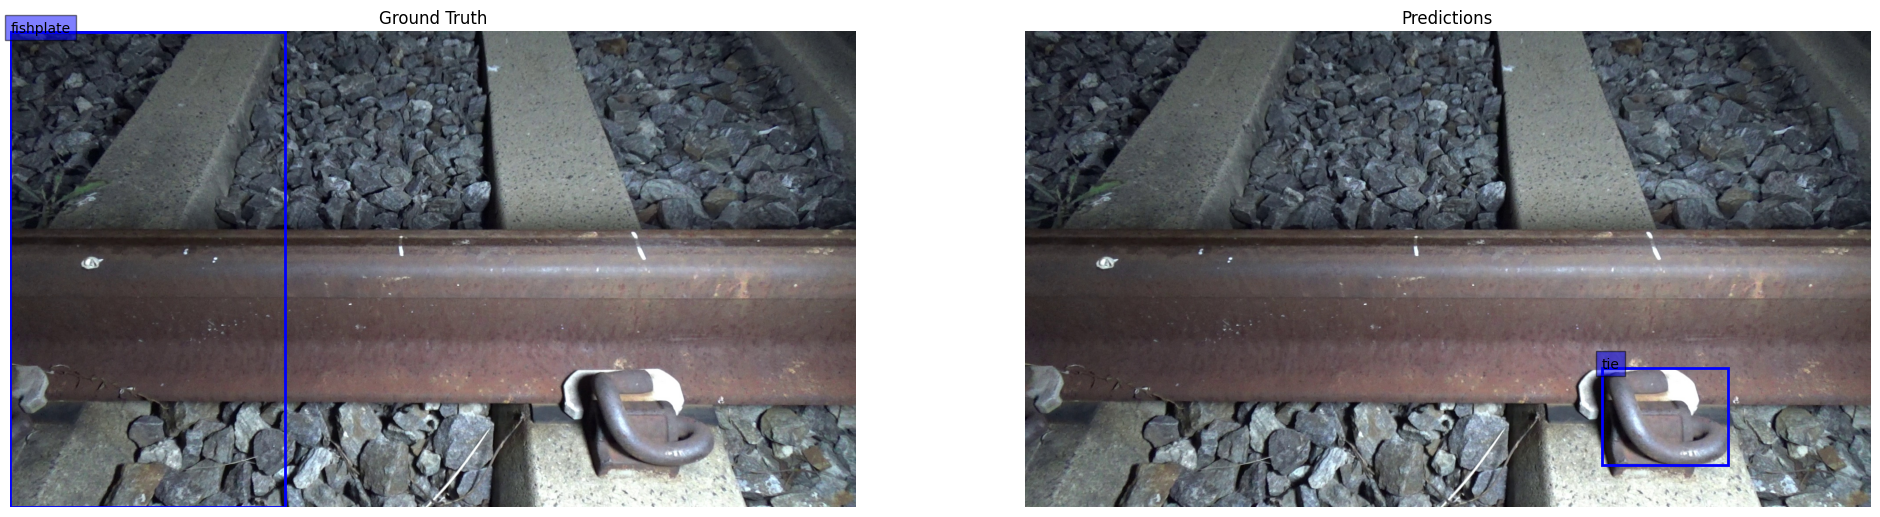

In [ ]:
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)):
        idx_list = []
        for idx, score in enumerate(preds[id]['scores']):
            if score > threshold:
                idx_list.append(idx)
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]
    return preds

def plot_image_with_annotations_and_predictions(img_tensor, annotations, predictions):
    # 텐서 이미지를 넘파이 배열로 변환
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = (img * 255).astype(np.uint8)

    # Ground truth에 대한 바운딩 박스 그리기
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(img)
    for box, label in zip(annotations['boxes'], annotations['labels']):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(xmin, ymin, class_names[label.item()], bbox={'facecolor': 'b', 'alpha': 0.5})
    ax[0].axis('off')
    ax[0].set_title("Ground Truth")

    # 예측값에 대한 바운딩 박스 그리기
    ax[1].imshow(img)
    for box, label in zip(predictions['boxes'], predictions['labels']):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(xmin, ymin, class_names[label.item()], bbox={'facecolor': 'b', 'alpha': 0.5})
    ax[1].axis('off')
    ax[1].set_title("Predictions")

    plt.show()

with torch.no_grad():
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(trained_model, imgs, 0.5)
        print(pred)
        break

_idx = 1
print("Target: ", annotations[_idx]['labels'])
print("Prediction: ", pred[_idx]['labels'])
plot_image_with_annotations_and_predictions(imgs[_idx], annotations[_idx], pred[_idx])

## trial 2


#### model 2
추가학습 파인튜닝을 통한 미세조정
추가 학습(파인튜닝)

모델을 훈련 모드로 설정하고 훈련 데이터 로더를 통해 이미지를 입력받아 손실을 계산, 추가로 5 에폭 학습

추가 학습 시간: 7228.17초 (약 2시간 0분 28초)


In [ ]:
# 모델 로드 함수
def load_model(model, load_path='model.pth'):
    model.load_state_dict(torch.load(load_path))
    print(f'Model loaded from {load_path}')
    return model


# 모델 초기화 및 가중치 로드
model = get_model_instance_segmentation(7)
model = load_model(model, '/content/drive/My Drive/Deeplearning/Teamproject/faster_rcnn_model2.pth')

# 모델을 디바이스로 전송
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 옵티마이저 및 스케줄러 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
early_stopping = EarlyStopping(patience=3, delta=0.01)

# 추가 학습 (파인튜닝) 함수
def fine_tune(train_data_loader, valid_data_loader, model, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        epoch_loss = 0
        for imgs, annotations in train_data_loader:
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()

        scheduler.step()
        epoch_time = time.time() - start
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f}s')

        # validation data에 대한 평가
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, annotations in valid_data_loader:
                imgs = list(img.to(device) for img in imgs)
                annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
                outputs = model(imgs)

                # 조기 종료를 위한 validation loss 설정
                dummy_loss = sum(output["scores"].mean().item() for output in outputs) / len(outputs)
                val_loss += dummy_loss

        val_loss /= len(valid_data_loader)
        print(f'Validation Loss: {val_loss:.4f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('best_model.pt'))
    return model

# 데이터 로더 설정
train_data_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=15, shuffle=True, num_workers=4, collate_fn=my_collate_fn)

valid_data_loader = torch.utils.data.DataLoader(
    valid_subset, batch_size=15, shuffle=False, num_workers=4, collate_fn=my_collate_fn)

# 추가 학습
fine_tuned_model = fine_tune(train_data_loader, valid_data_loader, model, optimizer, scheduler, num_epochs=5)


Model loaded from /content/drive/My Drive/Deeplearning/Teamproject/faster_rcnn_model2.pth
Epoch [1/5], Loss: 71.4446, Time: 1442.08s
Validation Loss: 0.3748
Epoch [2/5], Loss: 67.0279, Time: 1444.94s
Validation Loss: 0.3564
Epoch [3/5], Loss: 66.2010, Time: 1446.51s
Validation Loss: 0.3861
Epoch [4/5], Loss: 61.5460, Time: 1446.83s
Validation Loss: 0.4082
Epoch [5/5], Loss: 61.0579, Time: 1447.81s
Validation Loss: 0.4050
Early stopping


## model 2 test


In [ ]:
# test data loader 생성
test_dataset = RailroadDataset(test_df, IMG_PATH)
indices = np.random.choice(len(test_dataset), 100, replace=False)
test_subset = Subset(test_dataset, indices)

test_data_loader = DataLoader(
    test_subset,
    batch_size=5,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=lambda x: tuple(zip(*x))
)

# 테스트 데이터에 대 평가
test_results, annotations = evaluate_on_test_data(trained_model, test_data_loader)

# 각 임계값에서의 IoU accuracy 계산
iou_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
iou_accuracies = calculate_iou_accuracy(test_results, annotations, iou_thresholds)

# IoU accuracies 출력
for threshold, accuracy in iou_accuracies:
    print(f"IoU Threshold: {threshold}, IoU Accuracy: {accuracy:.2%}")

# mAP 계산 및 출력
mAP = calculate_mAP(test_results, annotations, iou_threshold=0.5)
print(f'mAP: {mAP}')

IoU Threshold: 0.4, IoU Accuracy: 99.00%
IoU Threshold: 0.5, IoU Accuracy: 88.00%
IoU Threshold: 0.6, IoU Accuracy: 82.00%
IoU Threshold: 0.7, IoU Accuracy: 71.00%
IoU Threshold: 0.8, IoU Accuracy: 54.00%
mAP: 0.19920672791261018


[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 319.0707,  286.6025,  890.6802, 1070.0924]], device='cuda:0'), 'labels': tensor([5], device='cuda:0'), 'scores': tensor([0.5128], device='cuda:0')}, {'boxes': tensor([[  36.8047,  846.8378, 1080.2048, 1071.2678]], device='cuda:0'), 'labels': tensor([5], device='cuda:0'), 'scores': tensor([0.5302], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[1375.2833,  507.4987, 1920.0000, 1080.0000]], device='cuda:0'), 'labels': tensor([5], device='cuda:0'), 'scores': tensor([0.5062], device='cuda:0')}]
Target:  tensor([2])
Prediction:  tensor([5], device='cuda:0')


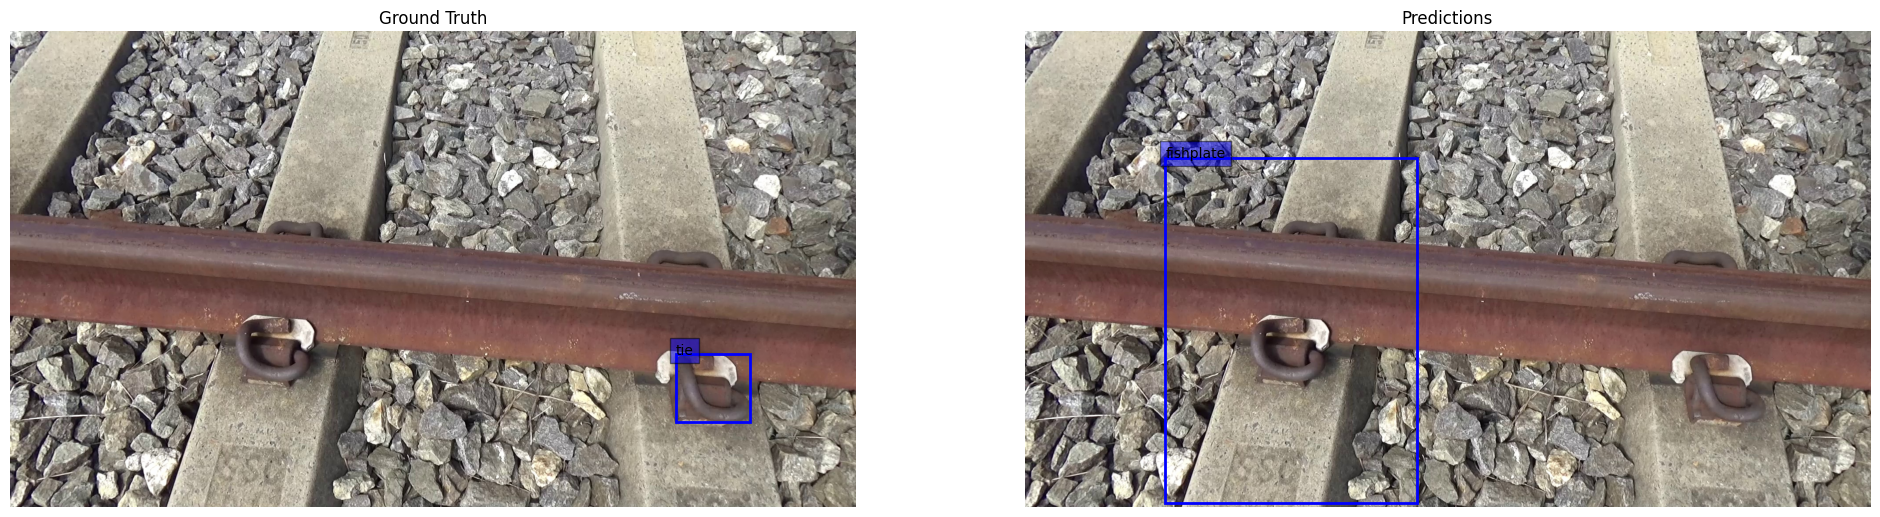

In [ ]:
    import torch
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)):
        idx_list = []
        for idx, score in enumerate(preds[id]['scores']):
            if score > threshold:
                idx_list.append(idx)
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]
    return preds

def plot_image_with_annotations_and_predictions(img_tensor, annotations, predictions):
    # 텐서 이미지를 넘파이 배열로 변환
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = (img * 255).astype(np.uint8)

    # Ground truth에 대한 바운딩 박스 그리기
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(img)
    for box, label in zip(annotations['boxes'], annotations['labels']):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(xmin, ymin, class_names[label.item()], bbox={'facecolor': 'b', 'alpha': 0.5})
    ax[0].axis('off')
    ax[0].set_title("Ground Truth")

    # 예측값에 대한 바운딩 박스 그리기
    ax[1].imshow(img)
    for box, label in zip(predictions['boxes'], predictions['labels']):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(xmin, ymin, class_names[label.item()], bbox={'facecolor': 'b', 'alpha': 0.5})
    ax[1].axis('off')
    ax[1].set_title("Predictions")

    plt.show()

with torch.no_grad():
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(trained_model, imgs, 0.5)
        print(pred)
        break

_idx = 1
print("Target: ", annotations[_idx]['labels'])
print("Prediction: ", pred[_idx]['labels'])
plot_image_with_annotations_and_predictions(imgs[_idx], annotations[_idx], pred[_idx])